# Unbalanced Decision tree - dataset: echo_popul.csv
## Task: Song popularity prediction

In [ ]:
%matplotlib inline
 
import pandas as pd
import numpy as np

# sklearn modules 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

from random import randint

import warnings
warnings.filterwarnings('ignore')


In [110]:
echo_popul = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_popul.csv')
echo_popul.set_index('track_id', inplace=True)
echo_popul.head()

,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,listens,duration,bit_rate,comments,interest,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,popularity
track_id,,,,,,,,,,,,,,,,,,
2,0.388990,0.386740,0.406370,0.000000,1293,168,256000,0,4656,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,not popular
3,0.388990,0.386740,0.406370,0.000000,514,237,256000,0,1470,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,not popular
5,0.388990,0.386740,0.406370,0.000000,1151,206,256000,0,1933,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,not popular
10,0.557339,0.614272,0.798387,0.005158,50135,161,192000,0,54881,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,popular
134,0.388990,0.386740,0.406370,0.000000,943,207,256000,0,1126,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,not popular


In [111]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
echo_popul['popularity'] = le.fit_transform(echo_popul['popularity'])

In [112]:
echo_popul['popularity'].value_counts()

0    12375
1      754
Name: popularity, dtype: int64

In [113]:
popul_labels = echo_popul['popularity']
echo_popul.drop('popularity', axis=1, inplace=True)

In [114]:
# shuffle and split into development set and internal test set
X_develop, X_test, y_develop, y_test = train_test_split(
echo_popul, popul_labels, test_size=0.30, random_state=42)

In [115]:
# check partition 
print(f"____Legend____\n0: not popular\n1: popular\n\nDevelopment set:\
\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
0: not popular
1: popular

Development set:
0    8665
1     525
Name: popularity, dtype: int64

Internal Test:
0    3710
1     229
Name: popularity, dtype: int64


In [116]:
# normalize data
scaler = MinMaxScaler()

scaler = StandardScaler(copy=False)
scaler.fit_transform(X_develop)
scaler.transform(X_test)

array([[ 0.1729799 , -0.23868617,  0.07918575, ..., -0.4850425 ,
         0.19906228, -0.69695608],
       [-0.22708222, -0.61516361, -0.28134725, ..., -0.38078801,
        -0.03218269,  0.49659837],
       [-1.70254702, -1.85976353, -1.61102509, ...,  0.78866415,
        -0.04957318, -0.95987087],
       ...,
       [-1.30459494, -0.50614887, -1.25239365, ..., -0.2814723 ,
         0.25857259,  1.69534937],
       [-0.2538649 , -0.95545597, -0.3054836 , ..., -0.44393578,
        -2.60214875, -0.80941051],
       [ 1.17032734,  0.32609229,  0.97798781, ...,  0.32297673,
        -0.59464654,  0.08517642]])

## Model selection: 
The parameters of the model are obtained after performing a stratified 10 fold cross validation through a coarse grid search

In [117]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [133]:
param_grid = {
               "max_depth": [3,4,5,6, None],
               "min_samples_leaf": [25,45,75,150,250,300],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 75}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 150}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 250}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 300}

Model with rank: 2
Mean validation score: 0.979 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.9

TypeError: 'NoneType' object is not subscriptable

Accuracy 0.9796902767199797
F1-score [0.98922704 0.82300885]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3710
           1       0.83      0.81      0.82       229

    accuracy                           0.98      3939
   macro avg       0.91      0.90      0.91      3939
weighted avg       0.98      0.98      0.98      3939



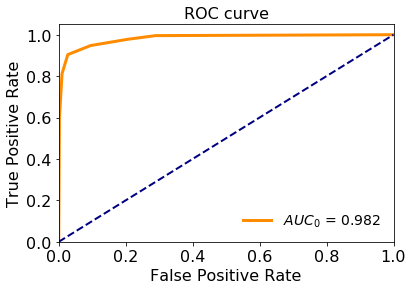

In [130]:
# unbalanced decision tree
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=3, min_samples_leaf= 25)
dtc.fit(X_develop,y_develop)

y_pred = dtc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

[[8571   94]
 [  88  437]]


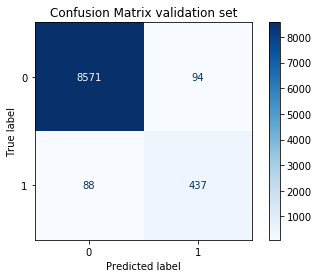

In [131]:
# confusion matrix
cm = plot_confusion_matrix(dtc,X_develop,y_develop,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix validation set')
print(cm.confusion_matrix)
plt.show()